In [1]:
import os, glob
import sys
import json
from PIL import Image
from collections import Counter

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import tifffile as tiff
import matplotlib.pyplot as plt
from tqdm import tqdm

import cv2

from sklearn.model_selection import KFold

sys.path.append("detection-wheel")

In [2]:
EPOCHS = 300

In [3]:

import os
import numpy as np
import torch
from PIL import Image


class PennFudanDatasetVal(torch.utils.data.Dataset):
    def __init__(self, imgs, masks, transforms):
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = imgs#sorted(glob.glob('/home/viktor/Documents/kaggle/hubmap-2023/experiments/mask-rcnn/new-dataset/train/image/*.png'))
        self.masks = masks#sorted(glob.glob('/home/viktor/Documents/kaggle/hubmap-2023/experiments/mask-rcnn/new-dataset/train/mask/*.png'))

    def __getitem__(self, idx):
        # load images and masks
        img_path = self.imgs[idx]
        mask_path = self.masks[idx]
        img = Image.open(img_path).convert("RGB")
        
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path).convert('L')
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        #masks = (mask == obj_ids[:, None, None])
        #print((obj_ids[:, None, None]).shape)
        #masks = mask == obj_ids[:, None, None]
        masks = [np.where(mask== obj_ids[i, None, None],1,0) for i in range(len(obj_ids))]
        masks = np.array(masks)

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.nonzero(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        try:
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            #print(area,area.shape,area.dtype)
        except:
            area = torch.tensor([[0],[0]])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        
        #print(masks.shape)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        # print(img.shape, img.min(), img.max())
        return img, target

    def __len__(self):
        return len(self.imgs)

In [4]:
import transforms as T


import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import numpy as np
import torch
from PIL import Image
from torchvision.transforms import functional as F, InterpolationMode
from skimage.draw import polygon

class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, imgs, masks, mode='train'):
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = imgs
        self.masks = masks

        self.mode = mode
        
        
        labels_file = "/home/viktor/Documents/kaggle/hubmap-2023/kaggle-data/polygons.jsonl"
        with open(labels_file, 'r') as json_file:
            self.json_labels = [json.loads(line) for line in json_file]
            
        # get index for each 'id' 
        indices_map = {}
        for indx, label in enumerate(self.json_labels):
            indices_map[label['id']] = indx
        
        self.indices_map = indices_map
        
        if self.mode == 'train':
            self.alb_transform = A.Compose([
                
                
                    A.Rotate(limit=90, p=0.9),
                    A.ShiftScaleRotate(p=0.5),
                    A.RandomBrightnessContrast(p=0.2),
                    A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=0.2),
                    A.RandomGamma(p=0.2),
                    # A.RandomCrop(height=256, width=256, p=0.5),
                    A.RandomResizedCrop(height=512, width=512, p=0.5),
                    A.Affine(p=0.5),
                    A.Downscale(scale_min=0.1, scale_max=0.5, p=0.5),
                    A.CoarseDropout(max_holes=8, max_height=32, max_width=32, mask_fill_value=0, p=0.3),
                    A.ShiftScaleRotate(shift_limit=0, scale_limit=0, p=0.3),
                    
                    
                    A.Normalize(
                        mean= [0] * 3,
                        std= [1] * 3
                    ),
                
                
                    ToTensorV2(transpose_mask=True),
                ])
            
            self.random_zoom_out = T.Compose([T.RandomZoomOut(p=0.8)])
        else:
            self.alb_transform = A.Compose([
                    
                    A.Normalize(
                        mean= [0] * 3,
                        std= [1] * 3
                    ),
                
                
                    ToTensorV2(transpose_mask=True),
                ])
            
        

    def __getitem__(self, idx):
        
        num_objs = 0
        while num_objs == 0:
        
            idx = np.random.randint(0, len(self.imgs))
            
            # load images and masks
            img_path = self.imgs[idx]
            mask_path = self.masks[idx] # '/home/viktor/Documents/kaggle/hubmap-2023/experiments/mask-rcnn/new-dataset/train/mask/0006ff2aa7cd_mask.png'
            
            
            
            # load image
            img = Image.open(img_path).convert("RGB")
            img = np.array(img)
            
            # load mask, but first get the id
            mask_id = mask_path.split('/')[-1].split('_')[0]
            
            mask = np.zeros((512, 512), dtype=np.float32)
            
            
            mask_id_indx = self.indices_map[mask_id]
            for annot in self.json_labels[mask_id_indx]['annotations']:
                cords = annot['coordinates']
                if annot['type'] == "blood_vessel":
                    for cord in cords:
                        rr, cc = polygon(np.array([i[1] for i in cord]), np.asarray([i[0] for i in cord]))
                        mask[rr, cc] = 1
            
        
            # ---------------- Augmentations ----------------
            
            
            
            # albumentations
            transformed = self.alb_transform(image=img, mask=mask)
            
            img = transformed['image']
            mask = transformed['mask'].numpy()
            
            # return img, mask
            
            # print(img.shape, mask.shape)
            mask_uint8 = np.where(mask > 0.5, 1, 0).astype(np.uint8) * 255
                
            num_outputs, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_uint8)
            label_masks = [labels == i for i in range(num_outputs)]
            masks = []
            for m in label_masks:
                mask_m = mask * m
                if np.sum(mask_m) > 80:
                    masks.append(mask_m)
                    
            
            # -----------------------------------------------
            
            # get bounding box coordinates for each mask
            num_objs = len(masks)
            boxes = []
            
            
            
            
            
        
        
        for i in range(num_objs):
            pos = np.nonzero(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
    
    
        

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.tensor([idx])
        
        try:
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            #print(area,area.shape,area.dtype)
        except:
            area = torch.tensor([[0],[0]])
        
        
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target['num_objs'] = torch.tensor(num_objs)      
        target["image_id"] = image_id  
        target["area"] = area
        target["iscrowd"] = iscrowd

                
        if self.mode == 'train':
            img, target = self.random_zoom_out(img, target)
            
            rand_width_height = 512 # np.random.randint(512, 1024)
            # resize to 1024x1024
            new_width = rand_width_height
            new_height = rand_width_height
            orig_height, orig_width = img.shape[1:]
            # orig_height = img.size[1]
            # orig_width = img.size[0]
            
            img = F.resize(img, [new_height, new_width], interpolation=InterpolationMode.BILINEAR)

            if target is not None:
                target["boxes"][:, 0::2] *= new_width / orig_width
                target["boxes"][:, 1::2] *= new_height / orig_height
                if "masks" in target:
                    target["masks"] = F.resize(
                        target["masks"], [new_height, new_width], interpolation=InterpolationMode.NEAREST
                    )
            
        
        return img, target

    def __len__(self):
        return len(self.imgs)

In [5]:
train_img = sorted(glob.glob('/home/viktor/Documents/kaggle/hubmap-2023/experiments/mask-rcnn/new-dataset/train/image/*.png'))
train_mask = sorted(glob.glob('/home/viktor/Documents/kaggle/hubmap-2023/experiments/mask-rcnn/new-dataset/train/mask/*.png'))
dataset_train = PennFudanDataset(train_img, train_mask,  mode='train')

/home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1554: UserWarning: Using default interpolation INTER_NEAREST, which is sub-optimal.Please specify interpolation mode for downscale and upscale explicitly.For additional information see this PR https://github.com/albumentations-team/albumentations/pull/584
  warnings.warn(


/tmp/ipykernel_3583383/3676133421.py:158: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)


3


/tmp/ipykernel_3583383/3676133421.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343997789/work/torch/csrc/utils/tensor_new.cpp:245.)
  masks = torch.as_tensor(masks, dtype=torch.uint8)


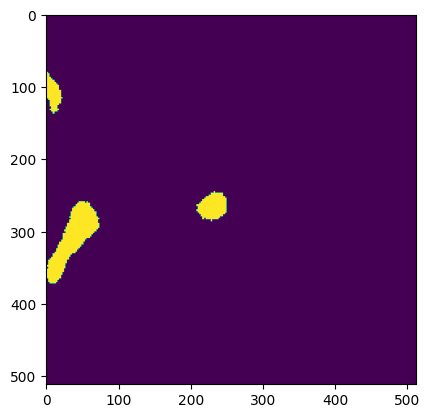

In [6]:
img, target = dataset_train[0]



masks = [m for m in target['masks'].numpy()]
print(len(masks))

plt.imshow(np.sum(masks, axis=0))

In [7]:
import torchvision
from torchvision.models import list_models
detection_models = list_models(module=torchvision.models.detection)
detection_models

['fasterrcnn_mobilenet_v3_large_320_fpn',
 'fasterrcnn_mobilenet_v3_large_fpn',
 'fasterrcnn_resnet50_fpn',
 'fasterrcnn_resnet50_fpn_v2',
 'fcos_resnet50_fpn',
 'keypointrcnn_resnet50_fpn',
 'maskrcnn_resnet50_fpn',
 'maskrcnn_resnet50_fpn_v2',
 'retinanet_resnet50_fpn',
 'retinanet_resnet50_fpn_v2',
 'ssd300_vgg16',
 'ssdlite320_mobilenet_v3_large']

In [8]:
import torchvision
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.resnet import ResNet50_Weights

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights="DEFAULT", weights_backbone=ResNet50_Weights.IMAGENET1K_V2)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [9]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
        transforms.append(T.RandomIoUCrop())
        transforms.append(T.RandomZoomOut())
        transforms.append(T.RandomPhotometricDistort())
        transforms.append(T.ScaleJitter())
        transforms.append(T.RandomShortestSize())
        
    return T.Compose(transforms)

In [10]:
from engine import train_one_epoch, evaluate
import utils

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [12]:
n_imgs = len(glob.glob('/home/viktor/Documents/kaggle/hubmap-2023/experiments/mask-rcnn/new-dataset/train/image/*'))
n_imgs



1622

In [13]:
# import sys

# # Create a custom function to log output
# def log_output(text):
#     with open('output.log', 'a') as f:
#         f.write(text)

# # Redirect stdout to the custom log function
# sys.stdout.write = log_output


In [14]:

kf = KFold(n_splits=5, shuffle=True, random_state=43)
for i, (train_index, test_index) in enumerate(kf.split(range(n_imgs))):
    if i!=0: continue
    all_imgs = sorted(glob.glob('/home/viktor/Documents/kaggle/hubmap-2023/experiments/mask-rcnn/new-dataset/train/image/*.png'))
    all_masks = sorted(glob.glob('/home/viktor/Documents/kaggle/hubmap-2023/experiments/mask-rcnn/new-dataset/train/mask/*.png'))
    
    all_imgs = np.array(all_imgs)
    all_masks = np.array(all_masks)
    train_img = all_imgs[train_index]
    train_mask = all_masks[train_index]
    
    
    # train_img = train_img
    
    val_img = all_imgs[test_index]
    val_mask = all_masks[test_index]
    dataset_train = PennFudanDataset(train_img, train_mask, mode='train')
    dataset_val = PennFudanDatasetVal(val_img, val_mask, get_transform(train=False))
    train_dl = torch.utils.data.DataLoader(
        dataset_train, batch_size=1, shuffle=True, num_workers=1, pin_memory=True, drop_last=True, collate_fn=utils.collate_fn)
    val_dl = torch.utils.data.DataLoader(
        dataset_val, batch_size=1, shuffle=False, num_workers=1, pin_memory=True,collate_fn=utils.collate_fn)
                                                        #os.cpu_count()
    
    
    model = get_model_instance_segmentation(num_classes=2)
    model.to(device)
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(params, lr=2e-5)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    # set linear warmup scheduler, with constant learning rate after warmup
    
    
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
                                                    base_lr=2e-5, 
                                                    max_lr=3e-3, 
                                                    step_size_up=40, 
                                                    step_size_down=40, 
                                                    mode='triangular2', 
                                                    cycle_momentum=False)

    # scheduler = torch.optim.lr_scheduler.LinearLR(optimizer,start_factor=0.01,
    #                                         end_factor=1,
    #                                         total_iters=10)

    train_areas = []

    for i, (images, targets) in tqdm(enumerate(dataset_train)):
        if i > 100:
            break
        area = targets['area'].cpu().numpy()
        train_areas.append(area)
        
        
    val_areas = []

    for i, (images, targets) in tqdm(enumerate(dataset_val)):
        if i > 100:
            break
        area = targets['area'].cpu().numpy()
        val_areas.append(area)
        
        

0it [00:00, ?it/s]/tmp/ipykernel_3583383/3676133421.py:158: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)
101it [00:58,  1.73it/s]
101it [00:01, 65.61it/s]


(0.0, 5000.0)

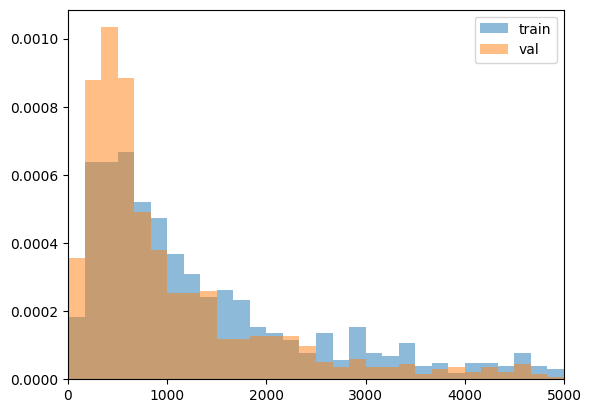

In [16]:
import matplotlib.pyplot as plt

plt.hist(np.concatenate(train_areas), bins=30, range=(0, 5000), alpha=0.5, label='train', density=True);
plt.hist(np.concatenate(val_areas), bins=30, range=(0, 5000), alpha=0.5, label='val', density=True);

plt.legend();
plt.xlim(0, 5000)
# plt.xscale('log')

## augm 2

## with zoom out

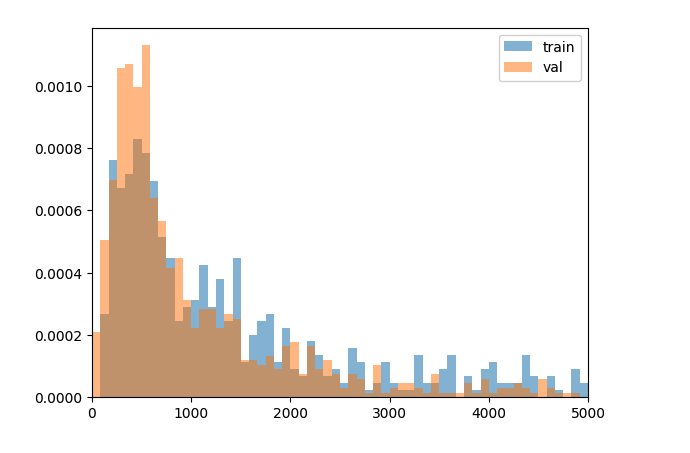

In [17]:
# import os
# import shutil

# source_dir = '/home/viktor/Documents/kaggle/hubmap-2023/experiments/yolo/yolov8-vanilla/YOLOv8x-maskrcnn-augms/datasets/train/images/'
# destination_dir = '/home/viktor/Documents/kaggle/hubmap-2023/experiments/yolo/yolov8-vanilla/YOLOv8x-maskrcnn-augms-2/datasets/train/images/'

# # Get a list of files in the source directory
# file_list = os.listdir(source_dir)

# # Create the destination directory if it doesn't exist
# os.makedirs(destination_dir, exist_ok=True)

# # Copy files one by one
# for file_name in tqdm(file_list):
#     source_path = os.path.join(source_dir, file_name)
#     destination_path = os.path.join(destination_dir, file_name)
#     shutil.copy(source_path, destination_path)

# print("Files copied successfully!")


100%|██████████| 22049/22049 [04:52<00:00, 75.49it/s] 

Files copied successfully!
